In [2]:
import fireducks.pandas as pd
import os

# Path to the extracted chunk files (from your Kaggle dataset structure)
extracted_chunks_path = "/kaggle/input/processed-chunks-1"  # Adjust if the path differs

# Combine all chunk files
all_chunks = []
for file_name in sorted(os.listdir(extracted_chunks_path)):  # Ensure files are combined in order
    if file_name.startswith("processed_chunk_") and file_name.endswith(".csv"):
        file_path = os.path.join(extracted_chunks_path, file_name)
        print(f"Loading {file_name}...")
        chunk = pd.read_csv(file_path)
        all_chunks.append(chunk)

# Concatenate all chunks into a single DataFrame
combined_data = pd.concat(all_chunks, ignore_index=True)

# Display combined data info
print("Combined data shape:", combined_data.shape)

Loading processed_chunk_0_50000.csv...
Loading processed_chunk_1000000_1050000.csv...
Loading processed_chunk_100000_150000.csv...
Loading processed_chunk_1050000_1100000.csv...
Loading processed_chunk_1100000_1150000.csv...
Loading processed_chunk_1150000_1200000.csv...
Loading processed_chunk_1200000_1250000.csv...
Loading processed_chunk_1250000_1300000.csv...
Loading processed_chunk_1300000_1350000.csv...
Loading processed_chunk_1350000_1400000.csv...
Loading processed_chunk_1400000_1450000.csv...
Loading processed_chunk_1450000_1500000.csv...
Loading processed_chunk_1500000_1550000.csv...
Loading processed_chunk_150000_200000.csv...
Loading processed_chunk_1550000_1600000.csv...
Loading processed_chunk_1600000_1650000.csv...
Loading processed_chunk_1650000_1700000.csv...
Loading processed_chunk_1700000_1750000.csv...
Loading processed_chunk_1750000_1800000.csv...
Loading processed_chunk_1800000_1850000.csv...
Loading processed_chunk_1850000_1900000.csv...
Loading processed_chunk_1

In [3]:
# Save the combined dataset as a CSV for future use
combined_data_path = "/kaggle/working/combined_processed_data.csv"
combined_data.to_csv(combined_data_path, index=False)
print(f"Combined data saved at: {combined_data_path}")
# Load the saved combined dataset
combined_data = pd.read_csv("/kaggle/working/combined_processed_data.csv")

# Check the dataset structure
print(combined_data.info())
print(combined_data.head())
# Check label distribution
print(combined_data['label'].value_counts())

Combined data saved at: /kaggle/working/combined_processed_data.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600000 entries, 0 to 3599999
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   review          object
 1   label           int64 
 2   cleaned_review  object
dtypes: int64(1), object(2)
memory usage: 82.4+ MB
None
                                              review  label  \
0  Stuning even for the non-gamer: This sound tra...      2   
1  The best soundtrack ever to anything.: I'm rea...      2   
2  Amazing!: This soundtrack is my favorite music...      2   
3  Excellent Soundtrack: I truly like this soundt...      2   
4  Remember, Pull Your Jaw Off The Floor After He...      2   

                                      cleaned_review  
0  stun non gamer sound track beautiful paint sen...  
1  good soundtrack read lot review say good game ...  
2  amazing soundtrack favorite music time hand in...  
3  excellent soundtrack t

In [4]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
X = combined_data['cleaned_review']  # Features (cleaned reviews)
y = combined_data['label']           # Labels (1 for neutral, 2 for positive)

# Perform train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Training samples: 2880000
Testing samples: 720000


In [5]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import multiprocessing
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import KFold
from scipy.stats import ttest_rel
import psutil
from copy import deepcopy
import random
import os
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

In [6]:
# Function to check memory usage
def check_memory():
    print(f"Memory usage: {psutil.virtual_memory().percent}%")

# --- Load Preprocessed Data ---
processed_dir = "/kaggle/input/processed-chunks-1/"
print("Loading preprocessed data from processed-chunks-1...")

# List all CSV files in the directory
csv_files = sorted([f for f in os.listdir(processed_dir) if f.endswith('.csv')])
print(f"Found {len(csv_files)} CSV files: {csv_files[:5]}...")

# Load and concatenate chunks
dataframes = []
for csv_file in tqdm(csv_files, desc="Loading CSV files"):
    file_path = os.path.join(processed_dir, csv_file)
    df = pd.read_csv(file_path)
    dataframes.append(df)

# Concatenate all chunks into one DataFrame
data = pd.concat(dataframes, ignore_index=True)
print(f"Total rows loaded: {len(data)}")

# Extract text and labels
text_column = 'cleaned_review'  # Preprocessed text column
label_column = 'label'         # Label column (1 or 2)
X = data[text_column].fillna("")  # Replace NaN with empty string
y = data[label_column].values     # Labels

# Check data integrity
print("Label distribution:", np.bincount(y - 1))  # Adjust labels to {0,1}
print("Number of empty cleaned reviews:", (X == "").sum())

# Shuffle the data to mix positive and negative reviews
print("Shuffling data...")
data_shuffled = data.sample(frac=1, random_state=42).reset_index(drop=True)
X_shuffled = data_shuffled[text_column].fillna("")
y_shuffled = data_shuffled[label_column].values

# Split into train (2.88M) and test (720K)
X_train_processed = X_shuffled[:2880000].tolist()
X_test_processed = X_shuffled[2880000:2880000 + 720000].tolist()
y_train = y_shuffled[:2880000]
y_test = y_shuffled[2880000:2880000 + 720000]

# Adjust labels from {1, 2} to {0, 1}
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

# Tokenize the text for Word2Vec
print("Tokenizing text data...")
X_train_tokenized = [simple_preprocess(text) for text in tqdm(X_train_processed, desc="Tokenizing X_train")]
X_test_tokenized = [simple_preprocess(text) for text in tqdm(X_test_processed, desc="Tokenizing X_test")]

# Train Word2Vec model
print("Training Word2Vec model...")
N_CORES = max(1, multiprocessing.cpu_count() // 2)
model = Word2Vec(
    sentences=X_train_tokenized, 
    vector_size=50,  # Embedding dimension
    window=5,        # Context window size
    min_count=5,     # Minimum word frequency
    workers=N_CORES, # Number of CPU cores
    epochs=5,        # Number of training iterations
    sg=1             # Use skip-gram
)
print("Word2Vec training complete!")

# Function to generate sentence embeddings by averaging word vectors
def get_word2vec_sentence_vector(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

# Generate embeddings
print("Converting tokenized text to Word2Vec embeddings...")
X_train_vectors = np.array([get_word2vec_sentence_vector(tokens, model) for tokens in tqdm(X_train_tokenized, desc="Embedding X_train")])
X_test_vectors = np.array([get_word2vec_sentence_vector(tokens, model) for tokens in tqdm(X_test_tokenized, desc="Embedding X_test")])
print("Word2Vec transformation complete!")
print(f"Train Word2Vec shape: {X_train_vectors.shape}")
print(f"Test Word2Vec shape: {X_test_vectors.shape}")

# --- Model Evaluation ---
N_CORES = multiprocessing.cpu_count() - 1

model_templates = {
    'SVM': LinearSVC(C=1.0, max_iter=5000, dual=False, random_state=42),
    'Logistic Regression': LogisticRegression(C=1.0, max_iter=5000, n_jobs=N_CORES, random_state=42),
    'Gaussian NB': GaussianNB(),
    'MLP Classifier': MLPClassifier(
        hidden_layer_sizes=(50,),  # Simplified to one layer
        max_iter=500,              # Reduced iterations
        learning_rate_init=0.001,
        early_stopping=True,       # Stop early if validation score plateaus
        validation_fraction=0.1,   # Use 10% of training data for validation
        n_iter_no_change=10,       # Stop if no improvement after 10 iterations
        random_state=42
    ),
    'XGBoost': XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.1, n_jobs=N_CORES, use_label_encoder=False, eval_metric='logloss', tree_method='hist', random_state=42),
    'LightGBM': lgb.LGBMClassifier(n_estimators=200, max_depth=5, n_jobs=N_CORES, random_state=42, verbose=-1)
}

# Step 1: Train and evaluate on test set with a subset
accuracies = {}
print("Training and evaluating models on test set...")
for name, model_template in model_templates.items():
    model = deepcopy(model_template)
    subset_idx = random.sample(range(len(X_train_vectors)), min(50000, len(X_train_vectors)))  # Reduced to 50,000
    X_train_subset = X_train_vectors[subset_idx]
    y_train_subset = y_train_adjusted[subset_idx]
    model.fit(X_train_subset, y_train_subset)
    y_pred = model.predict(X_test_vectors)
    y_pred_adjusted = y_pred + 1  # Adjust back to {1, 2}
    acc = accuracy_score(y_test, y_pred_adjusted)
    accuracies[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")
check_memory()

top_models = sorted(accuracies.items(), key=lambda x: x[1], reverse=True)[:2]
print("\nTop 2 models by accuracy:")
for name, acc in top_models:
    print(f"{name}: {acc:.4f}")

# Step 2: 10-Fold Cross-Validation with shuffled data
kf = KFold(n_splits=10, shuffle=True, random_state=42)
metrics = ['accuracy', 'f1', 'roc_auc']
results = {name: {metric: [] for metric in metrics} for name in model_templates.keys()}

print("\nPerforming 10-fold cross-validation...")
for name, model_template in model_templates.items():
    print(f"Cross-validating {name}...")
    for train_idx, val_idx in tqdm(kf.split(X_train_vectors), total=10, desc=f"Folds for {name}"):
        X_train_fold = X_train_vectors[train_idx]
        y_train_fold = y_train_adjusted[train_idx]
        X_val_fold = X_train_vectors[val_idx]
        y_val_fold = y_train_adjusted[val_idx]
        
        # Use a subset of 50,000 samples per fold (reduced from 100,000)
        subset_idx = random.sample(list(train_idx), min(50000, len(train_idx)))
        X_train_subset = X_train_vectors[subset_idx]
        y_train_subset = y_train_adjusted[subset_idx]
        
        model = deepcopy(model_template)
        model.fit(X_train_subset, y_train_subset)
        y_pred_fold = model.predict(X_val_fold)
        
        y_pred_fold_adjusted = y_pred_fold + 1
        y_val_fold_adjusted = y_val_fold + 1
        
        results[name]['accuracy'].append(accuracy_score(y_val_fold_adjusted, y_pred_fold_adjusted))
        results[name]['f1'].append(f1_score(y_val_fold_adjusted, y_pred_fold_adjusted, average='weighted'))
        if hasattr(model, "predict_proba"):
            y_prob_fold = model.predict_proba(X_val_fold)[:, 1]
            results[name]['roc_auc'].append(roc_auc_score(y_val_fold, y_prob_fold))
        else:
            results[name]['roc_auc'].append(np.nan)

# Display CV results
print("\n### 1. Perform K-Fold Cross-Validation and Report Detailed Performance Metrics")
print("Table: Performance of Models with Word2Vec Features (10-Fold Cross-Validation)")
print("| Model              | Accuracy (Mean ± SD) | F1-Score (Mean ± SD) | AUC-ROC (Mean ± SD) |")
print("|--------------------|---------------------|---------------------|--------------------|")
for name in model_templates.keys():
    acc_mean, acc_std = np.mean(results[name]['accuracy']), np.std(results[name]['accuracy'])
    f1_mean, f1_std = np.mean(results[name]['f1']), np.std(results[name]['f1'])
    auc_mean, auc_std = np.mean(results[name]['roc_auc']), np.std(results[name]['roc_auc'])
    print(f"| {name:<18} | {acc_mean:.2f} ± {acc_std:.2f}         | {f1_mean:.2f} ± {f1_std:.2f}         | {auc_mean:.2f} ± {auc_std:.2f}        |")

# Step 3: Statistical Significance Tests
top_model_1_name, top_model_2_name = top_models[0][0], top_models[1][0]
top_model_1_scores = results[top_model_1_name]['accuracy']
top_model_2_scores = results[top_model_2_name]['accuracy']

print("\n### 2. Conduct Statistical Significance Tests and Present p-Values")
print(f"Table: Statistical Significance of {top_model_1_name} and {top_model_2_name} vs. Other Models (Word2Vec)")
print("| Comparison                  | p-value (Accuracy) | Significant? |")
print("|-----------------------------|-------------------|--------------|")
for name in model_templates.keys():
    if name != top_model_1_name:
        other_scores = results[name]['accuracy']
        t_stat, p_value = ttest_rel(top_model_1_scores, other_scores)
        significant = "Yes" if p_value < 0.05 else "No"
        print(f"| {top_model_1_name} vs. {name:<15} | {p_value:.3f}             | {significant:<12} |")
for name in model_templates.keys():
    if name != top_model_2_name and name != top_model_1_name:
        other_scores = results[name]['accuracy']
        t_stat, p_value = ttest_rel(top_word_model_2_scores, other_scores)
        significant = "Yes" if p_value < 0.05 else "No"
        print(f"| {top_model_2_name} vs. {name:<15} | {p_value:.3f}             | {significant:<12} |")
check_memory()

Loading preprocessed data from processed-chunks-1...
Found 72 CSV files: ['processed_chunk_0_50000.csv', 'processed_chunk_1000000_1050000.csv', 'processed_chunk_100000_150000.csv', 'processed_chunk_1050000_1100000.csv', 'processed_chunk_1100000_1150000.csv']...


Loading CSV files: 100%|██████████| 72/72 [00:59<00:00,  1.20it/s]


Total rows loaded: 3600000
Label distribution: [1800000 1800000]
Number of empty cleaned reviews: 13
Shuffling data...
Tokenizing text data...


Tokenizing X_test: 100%|██████████| 720000/720000 [00:41<00:00, 17495.13it/s]


Training Word2Vec model...
Word2Vec training complete!
Converting tokenized text to Word2Vec embeddings...


Embedding X_test: 100%|██████████| 720000/720000 [01:17<00:00, 9307.10it/s]


Word2Vec transformation complete!
Train Word2Vec shape: (2880000, 50)
Test Word2Vec shape: (720000, 50)
Training and evaluating models on test set...
SVM Accuracy: 0.8501
Logistic Regression Accuracy: 0.8504
Gaussian NB Accuracy: 0.7287
MLP Classifier Accuracy: 0.8572
XGBoost Accuracy: 0.8467
LightGBM Accuracy: 0.8467
Memory usage: 79.7%

Top 2 models by accuracy:
MLP Classifier: 0.8572
Logistic Regression: 0.8504

Performing 10-fold cross-validation...
Cross-validating SVM...


Folds for SVM: 100%|██████████| 10/10 [00:26<00:00,  2.64s/it]


Cross-validating Logistic Regression...


Folds for Logistic Regression: 100%|██████████| 10/10 [00:30<00:00,  3.09s/it]


Cross-validating Gaussian NB...


Folds for Gaussian NB: 100%|██████████| 10/10 [00:20<00:00,  2.02s/it]


Cross-validating MLP Classifier...


Folds for MLP Classifier: 100%|██████████| 10/10 [01:34<00:00,  9.41s/it]


Cross-validating XGBoost...


Folds for XGBoost: 100%|██████████| 10/10 [00:55<00:00,  5.54s/it]


Cross-validating LightGBM...


Folds for LightGBM: 100%|██████████| 10/10 [01:09<00:00,  6.99s/it]



### 1. Perform K-Fold Cross-Validation and Report Detailed Performance Metrics
Table: Performance of Models with Word2Vec Features (10-Fold Cross-Validation)
| Model              | Accuracy (Mean ± SD) | F1-Score (Mean ± SD) | AUC-ROC (Mean ± SD) |
|--------------------|---------------------|---------------------|--------------------|
| SVM                | 0.85 ± 0.00         | 0.85 ± 0.00         | nan ± nan        |
| Logistic Regression | 0.85 ± 0.00         | 0.85 ± 0.00         | 0.93 ± 0.00        |
| Gaussian NB        | 0.73 ± 0.00         | 0.73 ± 0.00         | 0.81 ± 0.00        |
| MLP Classifier     | 0.86 ± 0.00         | 0.86 ± 0.00         | 0.93 ± 0.00        |
| XGBoost            | 0.85 ± 0.00         | 0.85 ± 0.00         | 0.93 ± 0.00        |
| LightGBM           | 0.85 ± 0.00         | 0.85 ± 0.00         | 0.93 ± 0.00        |

### 2. Conduct Statistical Significance Tests and Present p-Values
Table: Statistical Significance of MLP Classifier and Logistic Regr

NameError: name 'top_word_model_2_scores' is not defined

In [8]:
# Step 2: 10-Fold Cross-Validation with shuffled data
kf = KFold(n_splits=10, shuffle=True, random_state=42)
metrics = ['accuracy', 'f1', 'roc_auc']
results = {name: {metric: [] for metric in metrics} for name in model_templates.keys()}

print("\nPerforming 10-fold cross-validation...")
for name, model_template in model_templates.items():
    print(f"Cross-validating {name}...")
    fold_idx = 0
    for train_idx, val_idx in tqdm(kf.split(X_train_vectors), total=10, desc=f"Folds for {name}"):
        fold_idx += 1
        X_train_fold = X_train_vectors[train_idx]
        y_train_fold = y_train_adjusted[train_idx]
        X_val_fold = X_train_vectors[val_idx]
        y_val_fold = y_train_adjusted[val_idx]
        
        # Use a subset of 50,000 samples per fold
        subset_idx = random.sample(list(train_idx), min(50000, len(train_idx)))
        X_train_subset = X_train_vectors[subset_idx]
        y_train_subset = y_train_adjusted[subset_idx]
        
        model = deepcopy(model_template)
        model.fit(X_train_subset, y_train_subset)
        y_pred_fold = model.predict(X_val_fold)
        
        # Compute metrics using {0,1} labels directly
        acc = accuracy_score(y_val_fold, y_pred_fold)
        f1 = f1_score(y_val_fold, y_pred_fold, average='weighted')
        if hasattr(model, "predict_proba"):
            y_prob_fold = model.predict_proba(X_val_fold)[:, 1]
            auc = roc_auc_score(y_val_fold, y_prob_fold)
        else:
            auc = np.nan
        
        results[name]['accuracy'].append(acc)
        results[name]['f1'].append(f1)
        results[name]['roc_auc'].append(auc)
        
        # Print metrics for each fold
        print(f"Fold {fold_idx} - {name}: Accuracy={acc:.6f}, F1={f1:.6f}, AUC={auc:.6f}")

# Print all accuracies to check variation
for name in model_templates.keys():
    print(f"\n{name} accuracies: {[f'{acc:.6f}' for acc in results[name]['accuracy']]}")

# Display CV results with higher precision
print("\n### 1. Perform K-Fold Cross-Validation and Report Detailed Performance Metrics")
print("Table: Performance of Models with Word2Vec Features (10-Fold Cross-Validation)")
print("| Model              | Accuracy (Mean ± SD) | F1-Score (Mean ± SD) | AUC-ROC (Mean ± SD) |")
print("|--------------------|---------------------|---------------------|--------------------|")
for name in model_templates.keys():
    acc_mean = np.mean(results[name]['accuracy'])
    acc_std = np.std(results[name]['accuracy'])
    f1_mean = np.mean(results[name]['f1'])
    f1_std = np.std(results[name]['f1'])
    auc_mean = np.mean(results[name]['roc_auc'])
    auc_std = np.std(results[name]['roc_auc'])
    print(f"| {name:<18} | {acc_mean:.4f} ± {acc_std:.4f}   | {f1_mean:.4f} ± {f1_std:.4f}   | {auc_mean:.4f} ± {auc_std:.4f}   |")

# Step 3: Statistical Significance Tests
top_model_1_name, top_model_2_name = top_models[0][0], top_models[1][0]
top_model_1_scores = results[top_model_1_name]['accuracy']
top_model_2_scores = results[top_model_2_name]['accuracy']

print("\n### 2. Conduct Statistical Significance Tests and Present p-Values")
print(f"Table: Statistical Significance of {top_model_1_name} and {top_model_2_name} vs. Other Models (Word2Vec)")
print("| Comparison                  | p-value (Accuracy) | Significant? |")
print("|-----------------------------|-------------------|--------------|")
for name in model_templates.keys():
    if name != top_model_1_name:
        other_scores = results[name]['accuracy']
        t_stat, p_value = ttest_rel(top_model_1_scores, other_scores)
        significant = "Yes" if p_value < 0.05 else "No"
        print(f"| {top_model_1_name} vs. {name:<15} | {p_value:.6f}             | {significant:<12} |")
for name in model_templates.keys():
    if name != top_model_2_name and name != top_model_1_name:
        other_scores = results[name]['accuracy']
        t_stat, p_value = ttest_rel(top_model_2_scores, other_scores)
        significant = "Yes" if p_value < 0.05 else "No"
        print(f"| {top_model_2_name} vs. {name:<15} | {p_value:.6f}             | {significant:<12} |")
check_memory()


Performing 10-fold cross-validation...
Cross-validating SVM...


Folds for SVM:  10%|█         | 1/10 [00:01<00:17,  1.91s/it]

Fold 1 - SVM: Accuracy=0.850781, F1=0.850779, AUC=nan


Folds for SVM:  20%|██        | 2/10 [00:03<00:15,  1.98s/it]

Fold 2 - SVM: Accuracy=0.849740, F1=0.849737, AUC=nan


Folds for SVM:  30%|███       | 3/10 [00:05<00:14,  2.00s/it]

Fold 3 - SVM: Accuracy=0.850611, F1=0.850606, AUC=nan


Folds for SVM:  40%|████      | 4/10 [00:08<00:12,  2.02s/it]

Fold 4 - SVM: Accuracy=0.850399, F1=0.850399, AUC=nan


Folds for SVM:  50%|█████     | 5/10 [00:10<00:10,  2.14s/it]

Fold 5 - SVM: Accuracy=0.850681, F1=0.850679, AUC=nan


Folds for SVM:  60%|██████    | 6/10 [00:12<00:08,  2.04s/it]

Fold 6 - SVM: Accuracy=0.849865, F1=0.849862, AUC=nan


Folds for SVM:  70%|███████   | 7/10 [00:14<00:06,  2.18s/it]

Fold 7 - SVM: Accuracy=0.849215, F1=0.849208, AUC=nan


Folds for SVM:  80%|████████  | 8/10 [00:17<00:04,  2.22s/it]

Fold 8 - SVM: Accuracy=0.849615, F1=0.849614, AUC=nan


Folds for SVM:  90%|█████████ | 9/10 [00:19<00:02,  2.25s/it]

Fold 9 - SVM: Accuracy=0.848705, F1=0.848705, AUC=nan


Folds for SVM: 100%|██████████| 10/10 [00:21<00:00,  2.14s/it]


Fold 10 - SVM: Accuracy=0.849688, F1=0.849685, AUC=nan
Cross-validating Logistic Regression...


Folds for Logistic Regression:  10%|█         | 1/10 [00:04<00:39,  4.42s/it]

Fold 1 - Logistic Regression: Accuracy=0.850590, F1=0.850587, AUC=0.925987


Folds for Logistic Regression:  20%|██        | 2/10 [00:07<00:29,  3.74s/it]

Fold 2 - Logistic Regression: Accuracy=0.849795, F1=0.849795, AUC=0.926009


Folds for Logistic Regression:  30%|███       | 3/10 [00:10<00:22,  3.27s/it]

Fold 3 - Logistic Regression: Accuracy=0.850611, F1=0.850610, AUC=0.926109


Folds for Logistic Regression:  40%|████      | 4/10 [00:13<00:20,  3.36s/it]

Fold 4 - Logistic Regression: Accuracy=0.850792, F1=0.850792, AUC=0.926028


Folds for Logistic Regression:  50%|█████     | 5/10 [00:17<00:16,  3.40s/it]

Fold 5 - Logistic Regression: Accuracy=0.850448, F1=0.850446, AUC=0.925873


Folds for Logistic Regression:  60%|██████    | 6/10 [00:20<00:13,  3.30s/it]

Fold 6 - Logistic Regression: Accuracy=0.849458, F1=0.849457, AUC=0.925396


Folds for Logistic Regression:  70%|███████   | 7/10 [00:23<00:09,  3.26s/it]

Fold 7 - Logistic Regression: Accuracy=0.848833, F1=0.848832, AUC=0.924849


Folds for Logistic Regression:  80%|████████  | 8/10 [00:26<00:06,  3.26s/it]

Fold 8 - Logistic Regression: Accuracy=0.849889, F1=0.849885, AUC=0.925279


Folds for Logistic Regression:  90%|█████████ | 9/10 [00:30<00:03,  3.40s/it]

Fold 9 - Logistic Regression: Accuracy=0.848594, F1=0.848592, AUC=0.924925


Folds for Logistic Regression: 100%|██████████| 10/10 [00:33<00:00,  3.37s/it]


Fold 10 - Logistic Regression: Accuracy=0.850097, F1=0.850095, AUC=0.925714
Cross-validating Gaussian NB...


Folds for Gaussian NB:  10%|█         | 1/10 [00:02<00:19,  2.20s/it]

Fold 1 - Gaussian NB: Accuracy=0.724767, F1=0.724549, AUC=0.807808


Folds for Gaussian NB:  20%|██        | 2/10 [00:04<00:17,  2.14s/it]

Fold 2 - Gaussian NB: Accuracy=0.727979, F1=0.727752, AUC=0.810972


Folds for Gaussian NB:  30%|███       | 3/10 [00:06<00:14,  2.03s/it]

Fold 3 - Gaussian NB: Accuracy=0.727274, F1=0.727210, AUC=0.806229


Folds for Gaussian NB:  40%|████      | 4/10 [00:07<00:11,  1.92s/it]

Fold 4 - Gaussian NB: Accuracy=0.719795, F1=0.719605, AUC=0.804048


Folds for Gaussian NB:  50%|█████     | 5/10 [00:09<00:09,  1.96s/it]

Fold 5 - Gaussian NB: Accuracy=0.721278, F1=0.721068, AUC=0.804953


Folds for Gaussian NB:  60%|██████    | 6/10 [00:11<00:07,  1.95s/it]

Fold 6 - Gaussian NB: Accuracy=0.716372, F1=0.716098, AUC=0.800493


Folds for Gaussian NB:  70%|███████   | 7/10 [00:13<00:05,  1.91s/it]

Fold 7 - Gaussian NB: Accuracy=0.731670, F1=0.731588, AUC=0.810998


Folds for Gaussian NB:  80%|████████  | 8/10 [00:15<00:03,  1.87s/it]

Fold 8 - Gaussian NB: Accuracy=0.727233, F1=0.727075, AUC=0.808749


Folds for Gaussian NB:  90%|█████████ | 9/10 [00:17<00:01,  1.83s/it]

Fold 9 - Gaussian NB: Accuracy=0.731549, F1=0.731521, AUC=0.809408


Folds for Gaussian NB: 100%|██████████| 10/10 [00:19<00:00,  1.90s/it]


Fold 10 - Gaussian NB: Accuracy=0.717253, F1=0.717008, AUC=0.802086
Cross-validating MLP Classifier...


Folds for MLP Classifier:  10%|█         | 1/10 [00:13<02:04, 13.83s/it]

Fold 1 - MLP Classifier: Accuracy=0.857538, F1=0.857529, AUC=0.933355


Folds for MLP Classifier:  20%|██        | 2/10 [00:28<01:53, 14.20s/it]

Fold 2 - MLP Classifier: Accuracy=0.857896, F1=0.857871, AUC=0.933757


Folds for MLP Classifier:  30%|███       | 3/10 [00:42<01:38, 14.00s/it]

Fold 3 - MLP Classifier: Accuracy=0.858424, F1=0.858391, AUC=0.933994


Folds for MLP Classifier:  40%|████      | 4/10 [00:51<01:12, 12.01s/it]

Fold 4 - MLP Classifier: Accuracy=0.856115, F1=0.856103, AUC=0.931660


Folds for MLP Classifier:  50%|█████     | 5/10 [00:57<00:50, 10.04s/it]

Fold 5 - MLP Classifier: Accuracy=0.854108, F1=0.854106, AUC=0.929914


Folds for MLP Classifier:  60%|██████    | 6/10 [01:10<00:44, 11.05s/it]

Fold 6 - MLP Classifier: Accuracy=0.857219, F1=0.857218, AUC=0.932811


Folds for MLP Classifier:  70%|███████   | 7/10 [01:19<00:31, 10.39s/it]

Fold 7 - MLP Classifier: Accuracy=0.855236, F1=0.855213, AUC=0.931691


Folds for MLP Classifier:  80%|████████  | 8/10 [01:32<00:22, 11.12s/it]

Fold 8 - MLP Classifier: Accuracy=0.856431, F1=0.856408, AUC=0.933119


Folds for MLP Classifier:  90%|█████████ | 9/10 [01:44<00:11, 11.37s/it]

Fold 9 - MLP Classifier: Accuracy=0.856139, F1=0.856139, AUC=0.932319


Folds for MLP Classifier: 100%|██████████| 10/10 [01:53<00:00, 11.35s/it]


Fold 10 - MLP Classifier: Accuracy=0.855868, F1=0.855868, AUC=0.931723
Cross-validating XGBoost...


Folds for XGBoost:  10%|█         | 1/10 [00:05<00:51,  5.72s/it]

Fold 1 - XGBoost: Accuracy=0.847854, F1=0.847842, AUC=0.925747


Folds for XGBoost:  20%|██        | 2/10 [00:11<00:45,  5.69s/it]

Fold 2 - XGBoost: Accuracy=0.847722, F1=0.847717, AUC=0.925832


Folds for XGBoost:  30%|███       | 3/10 [00:16<00:38,  5.56s/it]

Fold 3 - XGBoost: Accuracy=0.847521, F1=0.847516, AUC=0.925955


Folds for XGBoost:  40%|████      | 4/10 [00:22<00:33,  5.52s/it]

Fold 4 - XGBoost: Accuracy=0.847667, F1=0.847665, AUC=0.925956


Folds for XGBoost:  50%|█████     | 5/10 [00:27<00:27,  5.45s/it]

Fold 5 - XGBoost: Accuracy=0.847851, F1=0.847845, AUC=0.925556


Folds for XGBoost:  60%|██████    | 6/10 [00:32<00:21,  5.38s/it]

Fold 6 - XGBoost: Accuracy=0.846163, F1=0.846158, AUC=0.924760


Folds for XGBoost:  70%|███████   | 7/10 [00:38<00:16,  5.38s/it]

Fold 7 - XGBoost: Accuracy=0.846670, F1=0.846659, AUC=0.924337


Folds for XGBoost:  80%|████████  | 8/10 [00:43<00:10,  5.44s/it]

Fold 8 - XGBoost: Accuracy=0.845451, F1=0.845448, AUC=0.924391


Folds for XGBoost:  90%|█████████ | 9/10 [00:49<00:05,  5.44s/it]

Fold 9 - XGBoost: Accuracy=0.846587, F1=0.846583, AUC=0.925203


Folds for XGBoost: 100%|██████████| 10/10 [00:54<00:00,  5.47s/it]


Fold 10 - XGBoost: Accuracy=0.846861, F1=0.846858, AUC=0.925323
Cross-validating LightGBM...


Folds for LightGBM:  10%|█         | 1/10 [00:06<01:01,  6.83s/it]

Fold 1 - LightGBM: Accuracy=0.846604, F1=0.846599, AUC=0.924926


Folds for LightGBM:  20%|██        | 2/10 [00:13<00:53,  6.71s/it]

Fold 2 - LightGBM: Accuracy=0.847326, F1=0.847322, AUC=0.925552


Folds for LightGBM:  30%|███       | 3/10 [00:20<00:47,  6.85s/it]

Fold 3 - LightGBM: Accuracy=0.847812, F1=0.847801, AUC=0.926005


Folds for LightGBM:  40%|████      | 4/10 [00:27<00:40,  6.83s/it]

Fold 4 - LightGBM: Accuracy=0.847618, F1=0.847614, AUC=0.925983


Folds for LightGBM:  50%|█████     | 5/10 [00:34<00:35,  7.09s/it]

Fold 5 - LightGBM: Accuracy=0.847601, F1=0.847593, AUC=0.925650


Folds for LightGBM:  60%|██████    | 6/10 [00:41<00:28,  7.06s/it]

Fold 6 - LightGBM: Accuracy=0.847104, F1=0.847100, AUC=0.924893


Folds for LightGBM:  70%|███████   | 7/10 [00:48<00:21,  7.01s/it]

Fold 7 - LightGBM: Accuracy=0.846642, F1=0.846638, AUC=0.924735


Folds for LightGBM:  80%|████████  | 8/10 [00:55<00:14,  7.02s/it]

Fold 8 - LightGBM: Accuracy=0.846476, F1=0.846474, AUC=0.925085


Folds for LightGBM:  90%|█████████ | 9/10 [01:02<00:07,  7.05s/it]

Fold 9 - LightGBM: Accuracy=0.846149, F1=0.846142, AUC=0.924917


Folds for LightGBM: 100%|██████████| 10/10 [01:10<00:00,  7.00s/it]

Fold 10 - LightGBM: Accuracy=0.847576, F1=0.847570, AUC=0.925689

SVM accuracies: ['0.850781', '0.849740', '0.850611', '0.850399', '0.850681', '0.849865', '0.849215', '0.849615', '0.848705', '0.849688']

Logistic Regression accuracies: ['0.850590', '0.849795', '0.850611', '0.850792', '0.850448', '0.849458', '0.848833', '0.849889', '0.848594', '0.850097']

Gaussian NB accuracies: ['0.724767', '0.727979', '0.727274', '0.719795', '0.721278', '0.716372', '0.731670', '0.727233', '0.731549', '0.717253']

MLP Classifier accuracies: ['0.857538', '0.857896', '0.858424', '0.856115', '0.854108', '0.857219', '0.855236', '0.856431', '0.856139', '0.855868']

XGBoost accuracies: ['0.847854', '0.847722', '0.847521', '0.847667', '0.847851', '0.846163', '0.846670', '0.845451', '0.846587', '0.846861']

LightGBM accuracies: ['0.846604', '0.847326', '0.847812', '0.847618', '0.847601', '0.847104', '0.846642', '0.846476', '0.846149', '0.847576']

### 1. Perform K-Fold Cross-Validation and Report Detailed Per

In [9]:
# Replace the existing t-test section with this:
print("\n### 2. Conduct Statistical Significance Tests and Present p-Values")
print(f"Table: Statistical Significance of {top_model_1_name} and {top_model_2_name} vs. Other Models (Word2Vec)")
print("| Comparison                  | p-value (Accuracy) | Significant? |")
print("|-----------------------------|-------------------|--------------|")
for name in model_templates.keys():
    if name != top_model_1_name:
        other_scores = results[name]['accuracy']
        t_stat, p_value = ttest_rel(top_model_1_scores, other_scores)
        significant = "Yes" if p_value < 0.05 else "No"
        print(f"| {top_model_1_name} vs. {name:<15} | {p_value:.10f}         | {significant:<12} |")
for name in model_templates.keys():
    if name != top_model_2_name and name != top_model_1_name:
        other_scores = results[name]['accuracy']
        t_stat, p_value = ttest_rel(top_model_2_scores, other_scores)
        significant = "Yes" if p_value < 0.05 else "No"
        print(f"| {top_model_2_name} vs. {name:<15} | {p_value:.10f}         | {significant:<12} |")


### 2. Conduct Statistical Significance Tests and Present p-Values
Table: Statistical Significance of MLP Classifier and Logistic Regression vs. Other Models (Word2Vec)
| Comparison                  | p-value (Accuracy) | Significant? |
|-----------------------------|-------------------|--------------|
| MLP Classifier vs. SVM             | 0.0000000949         | Yes          |
| MLP Classifier vs. Logistic Regression | 0.0000001055         | Yes          |
| MLP Classifier vs. Gaussian NB     | 0.0000000000         | Yes          |
| MLP Classifier vs. XGBoost         | 0.0000000084         | Yes          |
| MLP Classifier vs. LightGBM        | 0.0000000050         | Yes          |
| Logistic Regression vs. SVM             | 0.8449721300         | No           |
| Logistic Regression vs. Gaussian NB     | 0.0000000000         | Yes          |
| Logistic Regression vs. XGBoost         | 0.0000005901         | Yes          |
| Logistic Regression vs. LightGBM        | 0.0000000653    

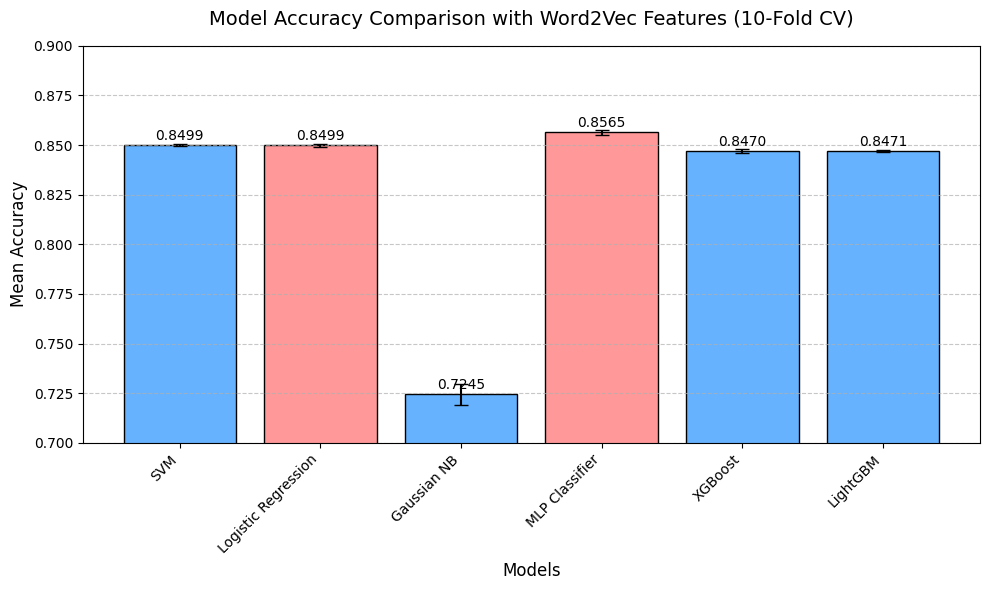


### Comparison of MLP Classifier and Logistic Regression vs. Other Models
              Model Accuracy (Mean ± SD) F1-Score (Mean ± SD) AUC-ROC (Mean ± SD) Edge over MLP Edge over Logistic Regression
                SVM      0.8499 ± 0.0006      0.8499 ± 0.0006           nan ± nan        0.0066                        0.0000
Logistic Regression      0.8499 ± 0.0007      0.8499 ± 0.0007     0.9256 ± 0.0004        0.0066                             -
        Gaussian NB      0.7245 ± 0.0053      0.7243 ± 0.0054     0.8066 ± 0.0035        0.1320                        0.1254
     MLP Classifier      0.8565 ± 0.0012      0.8565 ± 0.0012     0.9324 ± 0.0012             -                       -0.0066
            XGBoost      0.8470 ± 0.0008      0.8470 ± 0.0008     0.9253 ± 0.0006        0.0095                        0.0029
           LightGBM      0.8471 ± 0.0006      0.8471 ± 0.0006     0.9253 ± 0.0005        0.0094                        0.0028


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data from your cross-validation results
models = ['SVM', 'Logistic Regression', 'Gaussian NB', 'MLP Classifier', 'XGBoost', 'LightGBM']
mean_accuracy = [0.8499, 0.8499, 0.7245, 0.8565, 0.8470, 0.8471]
std_accuracy = [0.0006, 0.0007, 0.0053, 0.0012, 0.0008, 0.0006]
mean_f1 = [0.8499, 0.8499, 0.7243, 0.8565, 0.8470, 0.8471]
std_f1 = [0.0006, 0.0007, 0.0054, 0.0012, 0.0008, 0.0006]
mean_auc = [np.nan, 0.9256, 0.8066, 0.9324, 0.9253, 0.9253]
std_auc = [np.nan, 0.0004, 0.0035, 0.0012, 0.0006, 0.0005]

# Highlighted models
highlight_models = ['MLP Classifier', 'Logistic Regression']
colors = ['#FF9999' if model in highlight_models else '#66B2FF' for model in models]

# --- 1. Bar Chart of Mean Accuracies with Error Bars ---
plt.figure(figsize=(10, 6))
bars = plt.bar(models, mean_accuracy, yerr=std_accuracy, capsize=5, color=colors, edgecolor='black')
plt.title('Model Accuracy Comparison with Word2Vec Features (10-Fold CV)', fontsize=14, pad=15)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Mean Accuracy', fontsize=12)
plt.ylim(0.70, 0.90)  # Adjust based on your data range for better visibility
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.001, f'{yval:.4f}', 
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# --- 2. Table Comparing MLP Classifier and Logistic Regression vs. Others ---
# Create a DataFrame for the table
data = {
    'Model': models,
    'Accuracy (Mean ± SD)': [f'{mean:.4f} ± {std:.4f}' for mean, std in zip(mean_accuracy, std_accuracy)],
    'F1-Score (Mean ± SD)': [f'{mean:.4f} ± {std:.4f}' for mean, std in zip(mean_f1, std_f1)],
    'AUC-ROC (Mean ± SD)': [f'{mean:.4f} ± {std:.4f}' if not np.isnan(mean) else 'nan ± nan' 
                            for mean, std in zip(mean_auc, std_auc)]
}
df = pd.DataFrame(data)

# Filter for MLP Classifier and Logistic Regression comparison
comparison_df = df.copy()
mlp_idx = models.index('MLP Classifier')
logreg_idx = models.index('Logistic Regression')

# Calculate edge over MLP and Logistic Regression
comparison_df['Edge over MLP'] = ['-' if model == 'MLP Classifier' else 
                                  f'{mean_accuracy[mlp_idx] - mean_accuracy[i]:.4f}' 
                                  for i, model in enumerate(models)]
comparison_df['Edge over Logistic Regression'] = ['-' if model == 'Logistic Regression' else 
                                                  f'{mean_accuracy[logreg_idx] - mean_accuracy[i]:.4f}' 
                                                  for i, model in enumerate(models)]

# Reorder columns for clarity
comparison_df = comparison_df[['Model', 'Accuracy (Mean ± SD)', 'F1-Score (Mean ± SD)', 
                               'AUC-ROC (Mean ± SD)', 'Edge over MLP', 'Edge over Logistic Regression']]

# Style the table
print("\n### Comparison of MLP Classifier and Logistic Regression vs. Other Models")
print(comparison_df.to_string(index=False))

# Optional: Save the table as a CSV or image if needed
# comparison_df.to_csv('model_comparison.csv', index=False)